# Educational notebook based on Sargolini 2006


This tutorial demonstrates how to access the dataset published in [Sargolini et al. (Science, 2006)](https://doi.org/10.1126/science.1125572) using `dandi`.

The [dataset](https://dandiarchive.org/dandiset/000582/draft) contains spike times for recorded grid cells from the medial entorhinal cortex (MEC) in rats that explored two-dimensional environments. The behavioral data includes position from the tracking LED(s).


#### Contents:

* [Streaming NWB files](#stream-nwb)
* [Accessing data and metadata](#access-nwb)
* [Accessing behavior data](#position)
* [Accessing spike times](#spike-times)
* [Showing rate maps](#rate-maps)


## Streaming NWB files <a class="anchor" id="stream-nwb"></a>

This section demonstrates how to access the files on DANDI without downloading them.

Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from `PyNWB`.

The `DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive.

In [59]:
from dandi.dandiapi import DandiAPIClient

dandiset_id, nwbfile_path = "000582", "sub-10073/sub-10073_ses-17010302_behavior+ecephys.nwb" # file size ~15.6MB

# Get the location of the file on DANDI
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(nwbfile_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

Create a virtual filesystem using `fsspec` which will take care of requesting data from the S3 bucket whenever data is read from the virtual file.

In [60]:
from fsspec.implementations.cached import CachingFileSystem
from fsspec import filesystem
from h5py import File
from pynwb import NWBHDF5IO

# first, create a virtual filesystem based on the http protocol
fs=filesystem("http")

# create a cache to save downloaded data to disk (optional)
fs = CachingFileSystem(
    fs=fs,
    cache_storage="nwb-cache",  # Local folder for the cache
)

file_system = fs.open(s3_url, "rb")
file = File(file_system, mode="r")
# Open the file with NWBHDF5IO
io = NWBHDF5IO(file=file, load_namespaces=True)

nwbfile = io.read()
nwbfile

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning:

Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.5.1 is already loaded.

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning:

Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.2.0 is already loaded.



root pynwb.file.NWBFile at 0x140421195776112
Fields:
  acquisition: {
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    EEG <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ElectrodeGroup <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: The sample includes conjunctive cells and head direction cells from layers III and V of medial entorhinal cortex and have been published in Sargolini et al. (Science, 2006).
  experimenter: ['Sargolini, Francesca']
  file_create_date: [datetime.datetime(2023, 7, 22, 11, 15, 53, 940108, tzinfo=tzoffset(None, 7200))]
  identifier: 1d3b6249-2e71-4191-a933-0b1e50e6c8b4
  institution: Centre for the Biology of Memory, Norwegian University of Science and Technology
  keywords: <StrDataset for HDF5 dataset "keywords": shape (3,), type "|O">
  lab: Moser
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ecephys 

## Access data and metadata <a class="anchor" id="access-nwb"></a>

This section demonstrates how to access the data in the NWB files.

### Subject

The `nwbfile.subject` field holds information about the experimental subject, such as age (in [ISO 8601 Duration format](https://en.wikipedia.org/wiki/ISO_8601#Durations)), sex, and species in latin binomial nomenclature.

In [61]:
nwbfile.subject

subject pynwb.file.Subject at 0x140421195785376
Fields:
  age: P3M/P5M
  age__reference: birth
  description: A Long Evans rat.
  sex: M
  species: Rattus norvegicus
  subject_id: 10073
  weight: 0.35/0.45

## Accessing behavior data <a class="anchor" id="position"></a>

The "behavior" processing module holds the behavior data in the NWB file which can be accessed as
`nwbfile.processing["behavior"]`.

### Position

The position data is stored in a `SpatialSeries` object which can be accessed from the "Position" container as `nwbfile.processing["behavior"]["Position"]`.


Note that not all sessions have position data from two tracking LEDs.

In [62]:
spatial_series = nwbfile.processing["behavior"]["Position"]["SpatialSeriesLED1"]
spatial_series

SpatialSeriesLED1 pynwb.behavior.SpatialSeries at 0x140421195378224
Fields:
  comments: no comments
  conversion: 0.01
  data: <HDF5 dataset "data": shape (30000, 2), type "<f8">
  description: Position (x, y) for the first tracking LED.
  interval: 1
  offset: 0.0
  reference_frame: (0,0) is not known.
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (30000,), type "<f8">
  timestamps_unit: seconds
  unit: meters

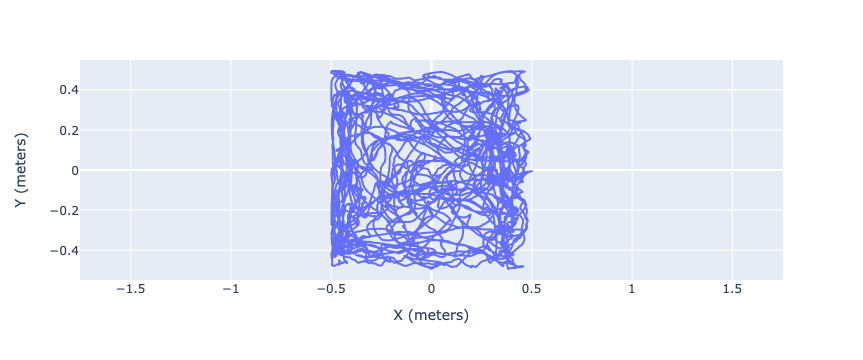

In [63]:
# Showing the trace of position

import plotly.express as px

fig = px.line(
    x=spatial_series.data[:, 0] * spatial_series.conversion,
    y=spatial_series.data[:, 1] * spatial_series.conversion,
    labels=dict(x="X (meters)", y="Y (meters)"),
)
fig.update_layout(yaxis=dict(scaleanchor="x"))

fig.show()

### For interactive visualization of the position

Visit [Neurosift](https://flatironinstitute.github.io/neurosift/?p=/nwb&url=https://dandiarchive.s3.amazonaws.com/blobs/ec1/842/ec1842a0-2229-4096-8dcd-d42b49f9dd49)


<img src="images/neurosift_position.png" alt="Neurosift" />

## Accessing spike times <a class="anchor" id="spike-times"></a>

The `Units` table holds the spike times which can be accessed as `nwbfile.units` and can also be converted to a pandas `DataFrame`.

In [8]:
nwbfile.units.to_dataframe()

unit_name                                        spike_times
id                                                             
0       t1c1  [0.7903958333333333, 0.794, 0.8111666666666667...
1       t2c1  [1.0451354166666667, 1.7003854166666668, 2.315...
2       t2c3  [0.18273958333333334, 0.5340729166666667, 0.57...
3       t3c1  [1.0358229166666666, 1.04803125, 1.69642708333...
4       t3c2  [2.43025, 2.4398333333333335, 3.17965625, 3.39...
5       t3c3  [2.1157708333333334, 2.425427083333333, 3.3630...
6       t3c4  [0.07945833333333334, 2.244947916666667, 3.173...
7       t4c1  [2.4301666666666666, 2.439770833333333, 3.1795...

### For interactive visualization of spike times

Visit [Neurosift](https://flatironinstitute.github.io/neurosift/?p=/nwb&url=https://dandiarchive.s3.amazonaws.com/blobs/ec1/842/ec1842a0-2229-4096-8dcd-d42b49f9dd49)

<img src="images/neurosift_units_and_position.png" alt="Neurosift" />

## Visualizing rate maps <a class="anchor" id="rate-maps"></a>

This section demonstrates how to show the rate maps of the recorded cells.
We will use [PYthon Neural Analysis Package](https://pynapple-org.github.io/pynapple/) (`pynapple`) to calculate the rate maps.

Using the `compute_2d_tuning_curves()` function we can compute firing rate as a function of position (map of neural activity as the animal explored the environment).

In [14]:
!pip install pynapple

  Obtaining dependency information for pynapple from https://files.pythonhosted.org/packages/71/e9/5aef10d51262170a1adc8ef0461cf3991b8bca236775775958c69d28b48b/pynapple-0.3.4-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.4 MB/s eta 0:00:00
  Obtaining dependency information for numba>=0.46.0 from https://files.pythonhosted.org/packages/3e/62/6fa62938b22365980e4e03eb75e3126a114b9f96b4bc96471ac42399ec20/numba-0.57.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Obtaining dependency information for tifffile from https://files.pythonhosted.org/packages/2d/e5/cc8a8ca43685006bb3ca56fab60707f3f74700844b18634db0b1e8b4b93f/tifffile-2023.7.18-py3-none-any.whl.metadata
  Obtaining dependency information for llvmlite<0.41,>=0.40.0dev0 from https://files.pythonhosted.org/packages/72/bd/6a98be69dc2f45ee86c432eea1ad2564a3c2e3cbd896f59949d533710e6b/llvmlite-0.40.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata

In [64]:
import pynapple as nap

position_over_time = nap.TsdFrame(
    d=spatial_series.data[:],
    t=spatial_series.timestamps[:],
    columns=["x","y"],
)
spike_times_group = nap.TsGroup({cell_id: nap.Ts(spikes) for cell_id, spikes in enumerate(nwbfile.units["spike_times"])})

num_bins = 15
rate_maps, position_bins = nap.compute_2d_tuning_curves(
    spike_times_group,
    position_over_time,
    num_bins,
)


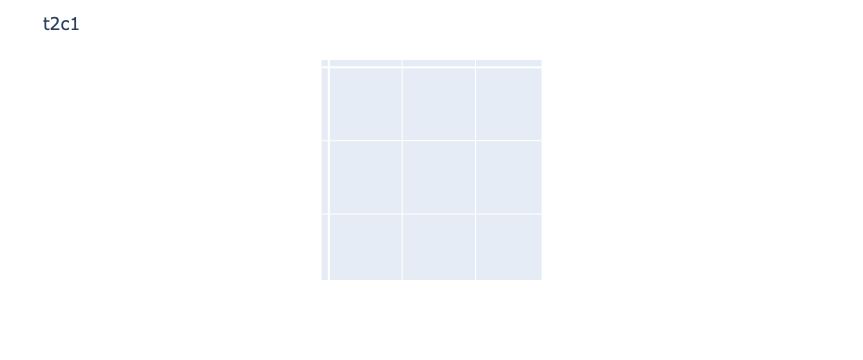

In [65]:
import plotly.express as px

cell_ind = 1
unit_name = nwbfile.units["unit_name"][cell_ind]

fig = px.imshow(rate_maps[cell_ind], color_continuous_scale="viridis")

fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(title=unit_name, coloraxis_showscale=False)


fig.show()

## Visualizing grid cells activity

To determine whether the firing fields of individual cells formed a grid structure, we will calculate the spatial autocorrelation for the rate map of each cell.

The autocorrelograms are based on Pearson’s product moment correlation coefficient with
corrections for edge effects and unvisited locations.  With λ (x, y) denoting the average rate of a cell at location (x, y), the autocorrelation between the fields with spatial lags of τx and τy was estimated as:

<img src="images/autocorrelation_equation.png" alt="Neurosift" />

where the summation is over all n pixels in λ (x, y) for which rate was estimated for both λ (x, y) and λ (x - τx, y - τy). Autocorrelations were not estimated for lags of τx, τy where n < 20.

The degree of spatial periodicity (gridness) can be determined for each cell by rotating the autocorrelation map for each cell in steps of 6 degrees (from 0 to 180 degrees) and computing the correlation between the rotated map and the original. The correlation is confined to the area defined by a circle around the peaks that are closest to the centre of the map, and the central peak is not included in the analysis.

The ‘gridness’ of a cell can be expressed as the difference between the lowest correlation at 60 and 120 degrees (where a peak correlation would be expected due to the triangular nature of the grid) and the highest correlation at 30, 90, and 150 degrees (where the minimum correlation would be expected). When the correlations at 60 and 120 degrees of rotation exceeded each of the correlations at 30, 90 and 150 degrees (gridness > 0), the cell was classified as a grid cell.


In [66]:
import numpy as np

def create_coer_arr(arr, rad_min=None, rad_max=None):
    # creating an array for correlation(tau_x, tau_y)
    # I will take tau_x from the range (-arr.shape[0]+1, arr.shape[0]-1) and the same for tau_y
    sh_x, sh_y = arr.shape
    # creating an array full of nan's
    coer_arr = np.full((2*sh_x-1, 2*sh_y-1), np.nan)
    for ii in range(0, 2*(sh_x-1)):
        for jj in range(0, 2*(sh_y-1)):
            # shifting tau_x/y
            tau_x = ii-sh_x+1
            tau_y = jj-sh_y+1
            # if rad_max and rad_min is provided, I only calculate the correlation for points between rad_min and rad_max
            if rad_max is not None and ((tau_x**2 + tau_y**2)**0.5 > rad_max):
                continue
            if rad_min is not None and ((tau_x**2 + tau_y**2)**0.5 < rad_min):
                continue
            coer_arr[ii, jj] = pearson_cor(arr, lag_x=tau_x, lag_y=tau_y)
    return coer_arr

def pearson_cor(arr, lag_x, lag_y):
    sh_x, sh_y = arr.shape
    if abs(lag_x) >= sh_x or abs(lag_y) >= sh_y:
        raise Exception(f"abs(lag_x), abs(lag_y) have to be smaller than {sh_x}, {sh_y}, but {lag_x}, {lag_y} provided")
    ij_valid = [] 
    for ii in range(0, sh_x):
        for jj in range(0, sh_y):
            # checking if the indices are withing the array
            if 0 <= ii-lag_x < sh_x and 0 <= jj-lag_y < sh_y:
                # checking if both values (in ii,jj and shifted) are not nan
                if not np.isnan(arr[ii, jj]) and not np.isnan(arr[ii-lag_x, jj-lag_y]):
                    ij_valid.append((ii, jj))
                
    # according to the paper they had this limit for number of points
    n = len(ij_valid)
    if n < 20:
        return np.nan

    cor = pearson_cor_eq(arr, ij_valid, lag_x, lag_y)
    #print(f"correlation: {cor}")
    return cor

def pearson_cor_eq(arr, ij_list, lag_x, lag_y):
    # repeating the equation from the page 6 of the suplement
    sum1, sum2, sum3, sum4, sum5, sum6, = 0, 0, 0, 0, 0, 0
    for (ii, jj) in ij_list:
        sum1 += arr[ii, jj] * arr[ii-lag_x, jj-lag_y]
        sum2 += arr[ii, jj] 
        sum3 += arr[ii-lag_x, jj-lag_y]
        
        sum4 += (arr[ii, jj])**2
        sum5 += (arr[ii-lag_x, jj-lag_y])**2
        sum6 += arr[ii-lag_x, jj-lag_y]
    
    numerator = len(ij_list) * sum1 - sum2 * sum3
    denominator = (len(ij_list) * sum4 - sum2**2)**0.5 * (len(ij_list) * sum5 - sum6**2)**0.5
    return numerator / denominator

def pearson_cor_2arr(arr1, arr2):
    sh_x, sh_y = arr1.shape
    sum1, sum2, sum3, sum4, sum5, sum6, = 0, 0, 0, 0, 0, 0

    for ii in range(0, sh_x):
        for jj in range(0, sh_y):
            sum1 += arr1[ii, jj] * arr2[ii, jj]
            sum2 += arr1[ii, jj] 
            sum3 += arr2[ii, jj]
        
            sum4 += (arr1[ii, jj])**2
            sum5 += (arr2[ii, jj])**2
            sum6 += arr2[ii, jj]
    n = sh_x * sh_y
    numerator = n * sum1 - sum2 * sum3
    denominator = (n * sum4 - sum2**2)**0.5 * (n * sum5 - sum6**2)**0.5
    return numerator / denominator

/opt/conda/lib/python3.10/site-packages/pynapple/process/tuning_curves.py:202: RuntimeWarning:

invalid value encountered in divide



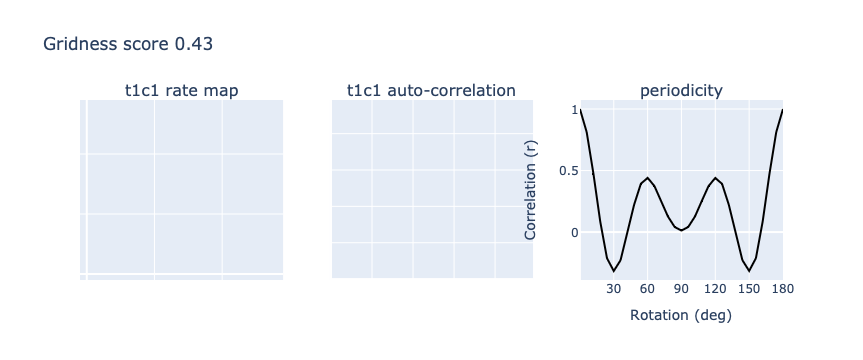

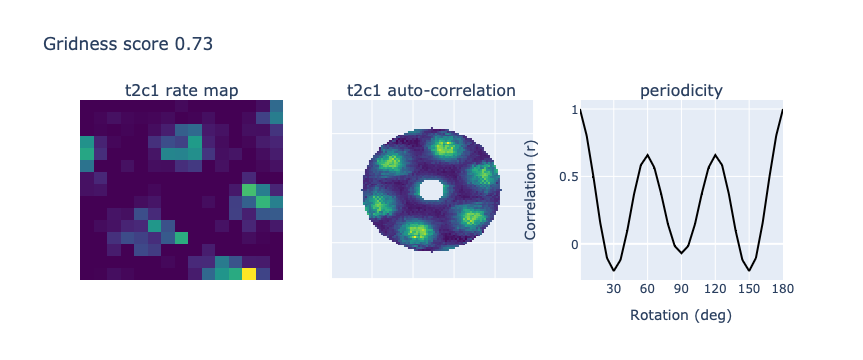

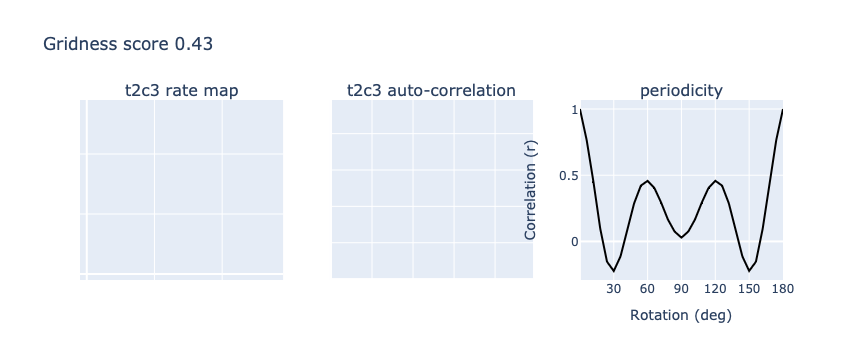

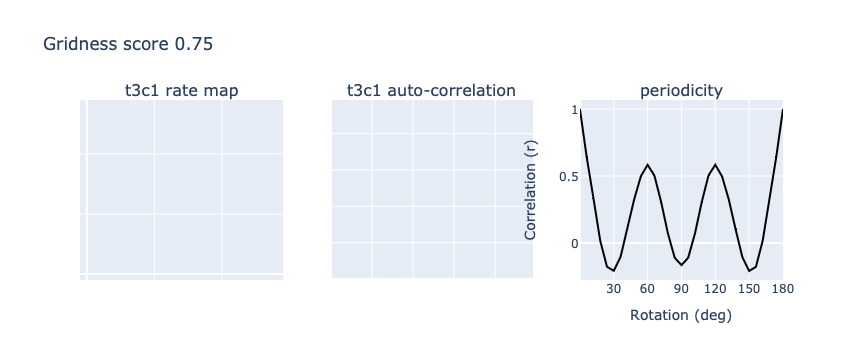

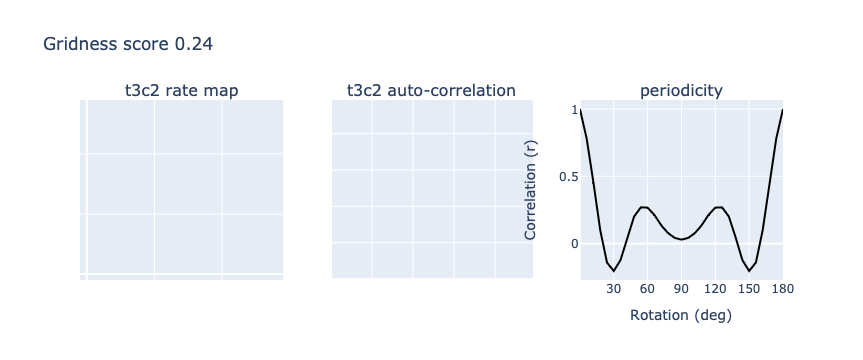

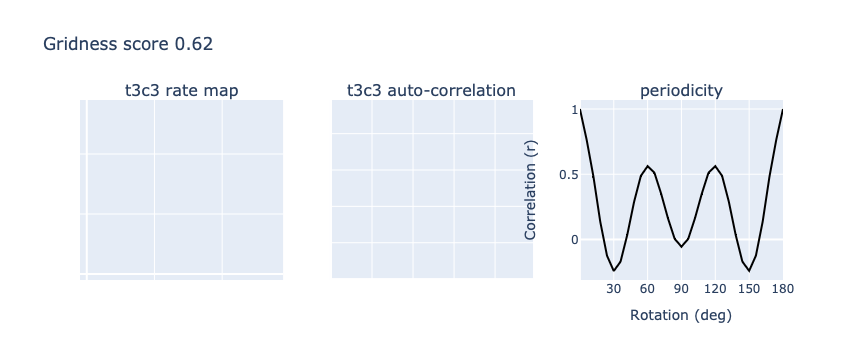

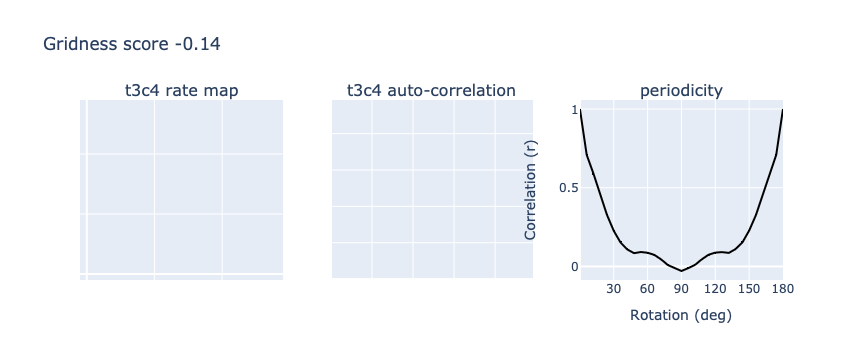

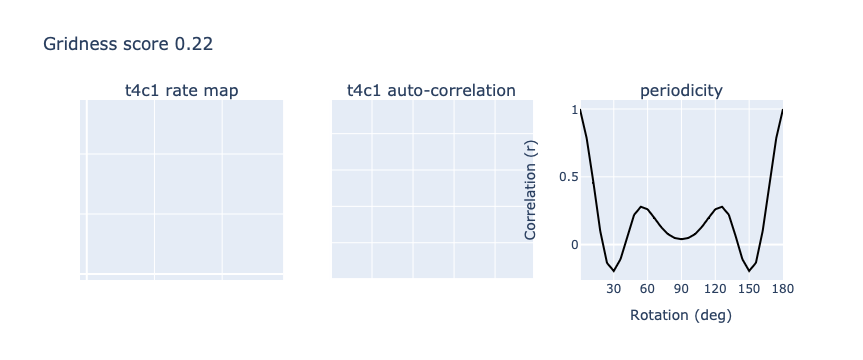

In [67]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.ndimage import rotate
import scipy

rate_maps_50_bin, _ = nap.compute_2d_tuning_curves(
    spike_times_group,
    position_over_time,
    50,
)

for cell_ind in range(len(rate_maps)):
    unit_name = nwbfile.units["unit_name"][cell_ind]
    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=(f'{unit_name} rate map', f'{unit_name} auto-correlation', "periodicity"),
    )

    rate_map_plot = go.Heatmap(z=rate_maps[cell_ind], colorscale='Viridis', showscale=False)
    fig.add_trace(rate_map_plot, row=1, col=1)

    # Compute auto-correlation
    autocorr = create_coer_arr(rate_maps_50_bin[cell_ind], rad_max=34, rad_min=6)
    autocorr_nonan = np.nan_to_num(autocorr, copy=True, nan=0.0)

    correlations = []
    angles = np.arange(0, 186, 6)
    for angle in angles:
        autocorr_nonan_rotated = rotate(autocorr_nonan, angle=angle, reshape=False)
        cor = pearson_cor_2arr(autocorr_nonan_rotated, autocorr_nonan)
        correlations.append(cor)
    
    gridness = max(correlations[10], correlations[20]) - max(correlations[5], correlations[15], correlations[25])
    gridness = np.round(gridness, 2)
    
    autocorr_rate_map = go.Heatmap(z=autocorr, colorscale='Viridis', showscale=False)
    fig.add_trace(autocorr_rate_map, row=1, col=2)
    
    line_trace = go.Scatter(
        x=angles,
        y=correlations,
        mode='lines',
        marker=dict(color="black"),
        
    )
    
    fig.add_trace(line_trace, row=1, col=3)

    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    
    fig.update_xaxes(showticklabels=True, row=1, col=3, title_text="Rotation (deg)")
    fig.update_yaxes(showticklabels=True, row=1, col=3, title_text="Correlation (r)")
    
    fig.update_layout(
        title=f"Gridness score {gridness}",
        xaxis3 = dict(
            tickmode="array",
            tickvals=[30, 60, 90, 120, 150, 180],
        )
    )

    fig.show()